In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from sklearn.kernel_ridge import KernelRidge

In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/1_code/')
from func import set_proj_env, my_get_cmap, get_fdr_p_df, node_strength, ave_control

In [4]:
parc_str = 'schaefer'
parc_scale = 200
edge_weight = 'streamlineCount'
parcel_names, parcel_loc, drop_parcels, num_parcels = set_proj_env(parc_str = parc_str, parc_scale = parc_scale, edge_weight = edge_weight)

### Setup directory variables

In [5]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/2_pipeline


In [6]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/3_output/figs


In [7]:
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)']
phenos_short = ['Ov. Psy.','Psy. (pos)','Psy. (neg)']

print(phenos)

metrics = ['str', 'ac']
algs = ['rr', 'krr_rbf']
scores = ['corr', 'rmse']

['Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg']


## Setup plots

In [8]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = my_get_cmap('pair')

## Load data

In [9]:
df_node = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', 'X.csv'))
df_node.set_index(['bblid', 'scanid'], inplace = True)

df_node_ac_overc = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', 'X_ac_c.csv'))
df_node_ac_overc.set_index(['bblid', 'scanid'], inplace = True)

df_pheno = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', 'y.csv'))
df_pheno.set_index(['bblid', 'scanid'], inplace = True)

c = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out', 'c.csv'))
c.set_index(['bblid', 'scanid'], inplace = True); print(c.shape)
c.columns

(1068, 4)


Index(['ageAtScan1', 'sex', 'mprage_antsCT_vol_TBV', 'dti64MeanRelRMS'], dtype='object')

### Nuisance regression

In [10]:
# Note, this nuisance regression made no difference.
# Leaving off for simplicity of reporting.

# nuis_reg = KernelRidge(kernel='rbf'); nuis_reg.fit(c, df_node)
# X_pred = nuis_reg.predict(c); df_node = df_node - X_pred

# nuis_reg = KernelRidge(kernel='rbf'); nuis_reg.fit(c, df_node_ac_overc)
# X_pred = nuis_reg.predict(c); df_node_ac_overc = df_node_ac_overc - X_pred

In [11]:
g = 0
gradient = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '2_compute_gradient', 'out','pnc_grads_template.txt'))[:,g]

In [12]:
A = np.load(os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'store', 'A.npy'))
A = np.mean(A, axis = 2)
np.any(np.isnan(A))

False

In [13]:
r_vals = pd.DataFrame(index = metrics, columns = phenos)
p_vals = pd.DataFrame(index = metrics, columns = phenos)

for metric in metrics:
    for pheno in phenos:
        X = df_node.filter(regex = metric).copy()
        y = df_pheno.loc[:,pheno].copy()
        
        X_y_corr = X.corrwith(y, method = 'spearman').values

        my_corr = sp.stats.spearmanr(gradient, X_y_corr)
        r_vals.loc[metric,pheno] = my_corr[0]
        p_vals.loc[metric,pheno] = my_corr[1]
        
p_vals = get_fdr_p_df(p_vals, rows = True)

In [14]:
r_vals

,Overall_Psychopathology,Psychosis_Positive,Psychosis_NegativeDisorg
str,-0.103675,-0.00378159,-0.0231576
ac,-0.280102,-0.292101,0.331508


In [15]:
r_vals[p_vals < .05]

,Overall_Psychopathology,Psychosis_Positive,Psychosis_NegativeDisorg
str,NaN,NaN,NaN
ac,-0.280102,-0.292101,0.331508


In [16]:
my_ac = ave_control(A)
my_str = node_strength(A)

my_ac = sp.stats.boxcox(my_ac)[0]
my_str = sp.stats.boxcox(my_str)[0]

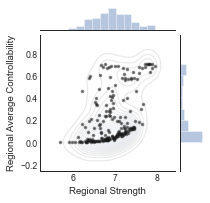

In [17]:
f = sns.jointplot(x = my_str, y = my_ac)
f.fig.set_figwidth(2.5)
f.fig.set_figheight(2.5)
# f.annotate(sp.stats.spearmanr)
f.plot_joint(sns.kdeplot, zorder = 0, n_levels = 20, alpha = 0.1)
f.plot_joint(plt.scatter, c = "k", s = 10, linewidth = 2, marker = ".", alpha = 0.5)
f.ax_joint.collections[0].set_alpha(0)
f.ax_joint.set_xlabel('Regional Strength')
f.ax_joint.set_ylabel('Regional Average Controllability')
f.ax_joint.tick_params(pad = -2)
f.savefig('regional_str_vs_ac.png', dpi = 300, bbox_inches = 'tight')

In [18]:
sp.stats.pearsonr(my_ac,my_str)

(0.4663590676186233, 3.40645877914501e-12)

In [19]:
sp.stats.spearmanr(my_ac,my_str)

SpearmanrResult(correlation=0.5318112952823821, pvalue=5.357370564549197e-16)

In [20]:
c_params = np.array([10, 100, 1000, 10000])
c_params

array([   10,   100,  1000, 10000])

In [21]:
ac_orig_r = np.zeros(c_params.shape,)
ac_str_r = np.zeros(c_params.shape,)

for i, c_param in enumerate(c_params):
    ac_tmp = ave_control(A, c = c_param)
    ac_tmp = sp.stats.boxcox(ac_tmp)[0]
    
    ac_orig_r[i] = sp.stats.spearmanr(my_ac,ac_tmp)[0]
    ac_str_r[i] = sp.stats.spearmanr(my_str,ac_tmp)[0]

In [22]:
ac_orig_r[-1]

0.5376434410860272

In [23]:
ac_str_r[-1]

0.9250611265281633

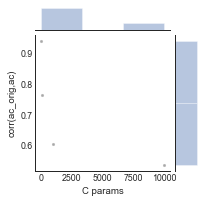

In [24]:
f = sns.jointplot(x = c_params, y = ac_orig_r)
f.fig.set_figwidth(2.5)
f.fig.set_figheight(2.5)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)
f.ax_joint.set_xlabel('C params')
f.ax_joint.set_ylabel('corr(ac_orig,ac)')
f.ax_joint.tick_params(pad = -2)
f.savefig('regional_c_vs_corr(ac_orig,ac).png', dpi = 300, bbox_inches = 'tight')

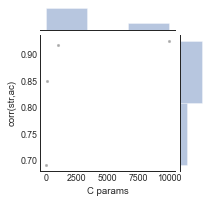

In [25]:
f = sns.jointplot(x = c_params, y = ac_str_r)
f.fig.set_figwidth(2.5)
f.fig.set_figheight(2.5)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)
f.ax_joint.set_xlabel('C params')
f.ax_joint.set_ylabel('corr(str,ac)')
f.ax_joint.tick_params(pad = -2)
f.savefig('regional_c_vs_corr(str,ac).png', dpi = 300, bbox_inches = 'tight')

## Correlation between (ac,str) cross-subject similarity and gradient value

In [26]:
df_str = df_node.filter(regex = 'str')
df_ac = df_node.filter(regex = 'ac')
ac_str_corr = df_str.corrwith(df_ac.set_axis(df_str.columns, axis='columns', inplace=False), method = 'pearson')

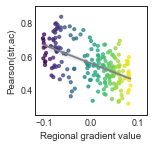

In [27]:
f, ax = plt.subplots()
f.set_figwidth(2)
f.set_figheight(2)
sns.regplot(x = gradient, y = ac_str_corr, color = 'gray', scatter = False)
plt.scatter(x = gradient, y = ac_str_corr, marker = 'o', s = 10, c = gradient, cmap = 'viridis', alpha=0.75, linewidth = 1)
ax.set_xlabel('Regional gradient value')
ax.set_ylabel('Pearson(str,ac)')
ax.set_ylim([0.25,0.9])
ax.set_xlim([-0.12,0.12])
ax.tick_params(pad = -2)
f.savefig('regional_gradient_'+str(g)+'_vs_corr(str,ac).svg', dpi = 300, bbox_inches = 'tight')

In [28]:
sp.stats.pearsonr(gradient,ac_str_corr)

(-0.5535848611136346, 1.8681278858728375e-17)

In [29]:
ac_str_corr.mean()

0.5588465221721748

10
0.6568096568218852
(-0.5082477554234892, 1.558263200950377e-14)
100
0.7356021616794278
(-0.47017531291923714, 2.1482556351835254e-12)
1000
0.8011358470403206
(-0.4655741278955286, 3.7426393995067895e-12)
10000
0.8834482514171904
(-0.41738670726879107, 7.812252045858413e-10)


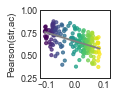

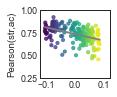

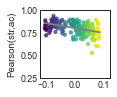

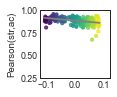

In [30]:
r_vals = np.zeros(len(c_params))

for i, c_param in enumerate(c_params):
    print(c_param)
    df_ac = df_node_ac_overc.filter(regex = 'ac_c'+str(c_param)+'_', axis = 1)
    ac_str_corr = df_str.corrwith(df_ac.set_axis(df_str.columns, axis='columns', inplace=False), method = 'pearson')
    print(ac_str_corr.mean())
    r_vals[i] = sp.stats.pearsonr(gradient,ac_str_corr)[0]
    print(sp.stats.pearsonr(gradient,ac_str_corr))

    f, ax = plt.subplots()
    f.set_figwidth(1.25)
    f.set_figheight(1.25)
    sns.regplot(x = gradient, y = ac_str_corr, color = 'gray', scatter = False)
    plt.scatter(x = gradient, y = ac_str_corr, marker = 'o', s = 10, c = gradient, cmap = 'viridis', alpha=0.75, linewidth = 1)
#     ax.set_xlabel('Regional gradient value')
    ax.set_xlabel('')
    ax.set_ylabel('Pearson(str,ac)')
    ax.set_ylim([0.25,1])
    ax.set_xlim([-0.12,0.12])
    ax.tick_params(pad = -2)
    f.savefig('regional_gradient_'+str(g)+'_vs_corr(str,ac)_c_'+str(c_param)+'.svg', dpi = 300, bbox_inches = 'tight')        